## Tunning
- https://arxiv.org/pdf/2309.06634

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover, BallCover, KNNCover, TrivialCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc

from functions import *

from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics

python(62586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)
dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

In [37]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False).sample(sample).reset_index(drop=True)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

In [102]:
# List of columns to select
select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', # '道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱',
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst, 59)
dist_dfA2 = preprocess(dataA2, select_lst, 5920) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
# rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

full_dist.head()

,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,經度,緯度,死亡,受傷
0,0.164031,-0.238809,-0.155973,-0.823857,-0.884725,0.459947,1.179138,1.147815,-1.635504,-0.910494,-0.168285,-0.689692,-0.442043,9.323858,-0.603438
1,0.164031,-0.238809,-0.155973,1.197830,1.151368,-0.702362,-1.603051,1.147815,0.431433,1.098305,-0.168285,0.346310,0.815256,9.323858,-2.756155
2,0.164031,1.338045,-0.155973,-0.823857,-0.884725,2.784566,-0.211956,-0.805725,0.431433,1.098305,-0.168285,-1.067200,-0.587754,9.323858,-2.756155
3,0.164031,1.338045,-0.155973,-0.823857,-0.884725,-0.702362,-0.211956,-0.805725,0.431433,1.098305,-0.168285,-1.301993,-1.203266,9.323858,-2.756155
4,0.164031,-0.238809,-0.155973,1.197830,1.151368,-0.702362,0.483591,-0.805725,0.431433,1.098305,-2.696365,1.345797,1.051146,9.323858,-2.756155


In [1]:
# lens1 = PCA(10).fit_transform(X1)

# mapper_algo1 = MapperAlgorithm(
#     cover = CubicalCover(
#         n_intervals = 3,
#         overlap_frac = 0.4
#     ),
#     clustering = FailSafeClustering(
#         clustering = AgglomerativeClustering(3, affinity='euclidean', linkage='ward'),
#         verbose = False)
# )
# mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

# mapper_plot1 = MapperLayoutInteractive(
#     mapper_graph1,
#     colors = rbind_data[['死亡']].to_numpy(),
#     cmap = 'jet',
#     agg = np.nanmean,
#     # agg = most_frequent_nonan,
#     dim = 3,
#     iterations = 30,
#     seed = 15,
#     width = 800,
#     height = 500)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [158]:
def resample_plot(A1, A2, selected, p_age = False):
    dist_dfA1 = preprocess(dataA1, selected, sample = 59)
    dist_dfA2 = preprocess(dataA2, selected, sample = 5920)

    rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
    
    rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
    rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
    if p_age == True:
        rbind_data = process_age(rbind_data)

    dist_df = process_data(rbind_data)
    scaler = StandardScaler()

    full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
    X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

    lens1 = PCA(10).fit_transform(X1)

    mapper_algo1 = MapperAlgorithm(
        cover = CubicalCover(
            n_intervals = 3,
            overlap_frac = 0.4
        ),
        clustering = FailSafeClustering(
            clustering = AgglomerativeClustering(3, affinity='euclidean', linkage='ward'),
            verbose = False)
    )
    mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

    mapper_plot1 = MapperLayoutInteractive(
        mapper_graph1,
        colors = rbind_data[['速限-第1當事者']].to_numpy(),
        cmap = 'jet',
        agg = np.nanmean,
        # agg = most_frequent_nonan,
        dim = 3,
        iterations = 30,
        seed = 15,
        width = 800,
        height = 500)
    
    return mapper_plot1

In [100]:
def get_full_info(mapper_plot):
    x = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
    y = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
    z = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

    threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

    import re
    data_tuple = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

    data = []
    for item in data_tuple:
        color = int(re.search(r'color: (\d+)', item).group(1))
        node = int(re.search(r'node: (\d+)', item).group(1))
        size = int(re.search(r'size: (\d+)', item).group(1))
        data.append({'color': color, 'node': node, 'size': size})
    component_info = pd.DataFrame(data)

    full_info = pd.concat([component_info, threeDimData], axis=1)

    mp_content_origin = vars(mapper_plot._MapperLayoutInteractive__graph)['_node']

    mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
    mp_content.reset_index(inplace=True)
    mp_content.rename(columns={'index': 'node'}, inplace=True)

    full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')
    full_info.iloc[:, 3:6]
    
    return full_info

## 步驟: 先算DBSCAN再算calinski，最後檢測常態

In [101]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

def get_calinski_from_db(input_data, eps):
    X = input_data.iloc[:, 3:6]

    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    input_data['label'] = labels
    # Cluster大於1才會計算
    if n_clusters_ > 1:
        filtered_labels = labels[labels != -1]
        filtered_X = X[labels != -1]
        score = calinski_harabasz_score(filtered_X, filtered_labels)
        silhouette_score_value = silhouette_score(filtered_X, filtered_labels)
    else:
        score = -1
        silhouette_score_value = -1
        
    return score, input_data, db, labels, n_clusters_, silhouette_score_value
# print('calinski: ', calinski_data[0])
# print('clusters: ', calinski_data[4])
# print('silhouette: ', calinski_data[5])

In [2]:
# import plotly.graph_objects as go

# mapper_plot1 = resample_plot(dataA1, dataA2, select_lst)
# full_info = get_full_info(mapper_plot1)
# calinski_data = get_calinski_from_db(full_info, 0.07)
# print(calinski_data[0])

# labels = calinski_data[3]
# db = calinski_data[2]
# n_clusters_ = calinski_data[4]

# unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# def matplotlib_to_plotly(cmap, alpha=1):
#     """rgba"""
#     return f'rgba({int(cmap[0]*255)}, {int(cmap[1]*255)}, {int(cmap[2]*255)}, {alpha})'

# # colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]  
# colors = [matplotlib_to_plotly(plt.cm.Spectral(each), alpha=0.8) for each in np.linspace(0, 1, len(unique_labels))]
# fig = go.Figure()

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # col = 'rgba(0,0,0,0)'
#         col = 'rgba(0,0,0,0)'

#     class_member_mask = labels == k

#     core_samples = full_info.iloc[:, 3:6][class_member_mask & core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=core_samples.iloc[:, 0],
#         y=core_samples.iloc[:, 1],
#         z=core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.8
#         ),
#         name=f'Cluster {k} Core'
#     ))

#     non_core_samples = full_info.iloc[:, 3:6][class_member_mask & ~core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=non_core_samples.iloc[:, 0],
#         y=non_core_samples.iloc[:, 1],
#         z=non_core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.5
#         ),
#         name=f'Cluster {k} Non-Core'
#     ))

# fig.update_layout(
#     title=f"Estimated number of clusters: {n_clusters_}",
#     margin=dict(l=0, r=0, b=0, t=0)
# )

# fig.show()

## 常態性檢測

In [129]:
calinski_lst = []
cluster_lst = []
silhouette_lst = []

import time

start_time = time.time()
for i in range(50):
    if i%10 == 0:
        print(i)
    
    mapper_plot1 = resample_plot(dataA1, dataA2, select_lst)
    full_info = get_full_info(mapper_plot1)
    calinski_data = get_calinski_from_db(full_info, 0.07)
    
    calinski_lst.append(calinski_data[0])
    cluster_lst.append(calinski_data[4])
    silhouette_lst.append(calinski_data[5])
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time)

0
10
20
30
40
Execution Time: 690.8470149040222


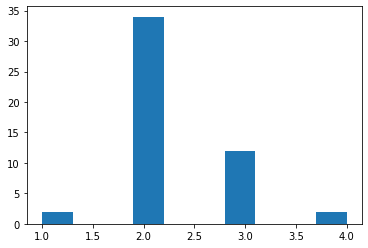

In [130]:
plt.hist(cluster_lst, bins=10)
plt.show()

## 檢定常態

In [131]:
from collections import Counter
count = Counter(cluster_lst)

# 計算總數
total = len(cluster_lst)

# 打印每個元素的百分比
for key in sorted(count):
    percent = (count[key] / total) * 100
    print(f"Cluster {key}: {percent:.2f}%")

Cluster 1: 4.00%
Cluster 2: 68.00%
Cluster 3: 24.00%
Cluster 4: 4.00%


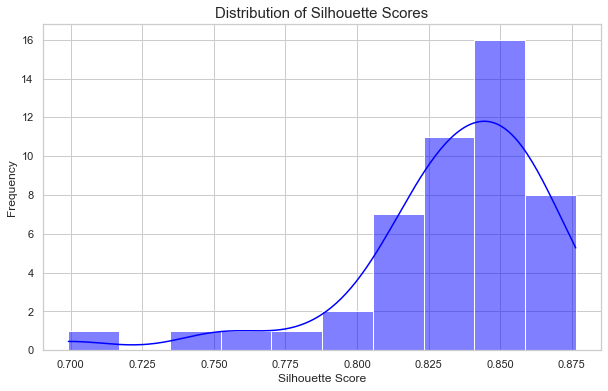

In [132]:
filtered_silhouettes = [x for x in silhouette_lst if x > 0]
# filtered_silhouettes = [x for x in filtered_silhouettes if x > 0.2]

import matplotlib.pyplot as plt
import seaborn as sns
# plt.hist(silhouette_lst, bins=30)
# plt.show()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(filtered_silhouettes, bins=10, kde=True, color="blue")

# 添加標題和標籤
plt.title("Distribution of Silhouette Scores", fontsize=15)
plt.xlabel("Silhouette Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# 顯示圖表
plt.show()

In [137]:
from scipy import stats
k2, p = stats.normaltest(silhouette_lst)

print("統計量:", k2)
print("P值:", p)

if p < 0.01:
    print("數據不符合常態分佈")
else:
    print("數據符合常態分佈")

統計量: 82.00692771475649
P值: 1.55747795348672e-18
數據不符合常態分佈


In [150]:
import statistics
mean_score = statistics.mean(filtered_silhouettes)
stdev_score = statistics.stdev(filtered_silhouettes)

print(f"平均值: {mean_score}")
print(f"標準差: {stdev_score}")

平均值: 0.8340038219101491
標準差: 0.03374711115718759


In [151]:
ks_statistic, p_value = stats.kstest(filtered_silhouettes, 'norm', args=(mean_score, stdev_score))
p_value

0.18490509746413697

In [142]:
import os
# silhouette_path = os.path.join('CalculatedData/抽樣分布/silhouette_lst.txt')
filtered_silhouettes_path = os.path.join('CalculatedData/抽樣分布/道路輪廓.txt')

# 將列表保存到文件中
# with open(silhouette_path, "w") as file:
#     for item in silhouette_lst:
#         file.write("%s\n" % item)
with open(filtered_silhouettes_path, "w") as file:
    for item in filtered_silhouettes:
        file.write("%s\n" % item)

## 所有資料集的常態性檢定

In [152]:
select_lst_full = [
    '天候名稱', '路面狀況-路面狀態名稱',
    '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '車輛撞擊部位大類別名稱-最初', '光線名稱','道路類別-第1當事者-名稱',
    '速限-第1當事者','道路型態大類別名稱', '事故位置大類別名稱', 
    '號誌-號誌種類名稱', '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱', '死亡受傷人數','經度', '緯度',
]

In [184]:
calinski_lst = []
cluster_lst = []
silhouette_lst = []

import time

start_time = time.time()
for i in range(50):
    if i%10 == 0:
        print(i)
    
    mapper_plot1 = resample_plot(dataA1, dataA2, select_lst_full, p_age = True)
    full_info = get_full_info(mapper_plot1)
    calinski_data = get_calinski_from_db(full_info, 0.08)
    
    calinski_lst.append(calinski_data[0])
    cluster_lst.append(calinski_data[4])
    silhouette_lst.append(calinski_data[5])
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time)

0
10
20
30
40
Execution Time: 1081.0324258804321


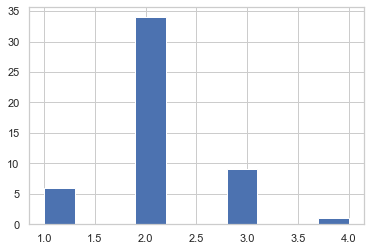

In [185]:
plt.hist(cluster_lst, bins=10)
plt.show()

In [186]:
from collections import Counter
count = Counter(cluster_lst)

# 計算總數
total = len(cluster_lst)

# 打印每個元素的百分比
for key in sorted(count):
    percent = (count[key] / total) * 100
    print(f"Cluster {key}: {percent:.2f}%")

Cluster 1: 12.00%
Cluster 2: 68.00%
Cluster 3: 18.00%
Cluster 4: 2.00%


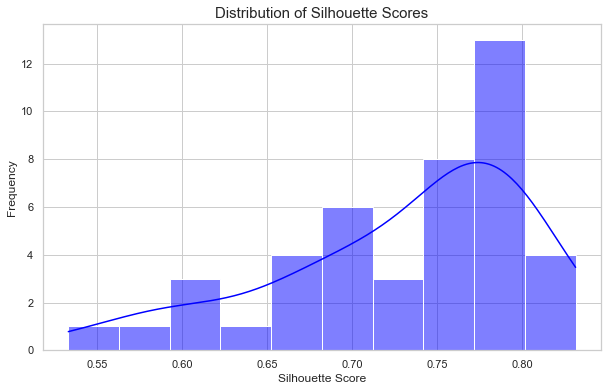

In [187]:
filtered_silhouettes = [x for x in silhouette_lst if x > 0]
# filtered_silhouettes = [x for x in filtered_silhouettes if x > 0.2]

import matplotlib.pyplot as plt
import seaborn as sns
# plt.hist(silhouette_lst, bins=30)
# plt.show()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(filtered_silhouettes, bins=10, kde=True, color="blue")

# 添加標題和標籤
plt.title("Distribution of Silhouette Scores", fontsize=15)
plt.xlabel("Silhouette Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# 顯示圖表
plt.show()

In [188]:
import statistics
mean_score = statistics.mean(filtered_silhouettes)
stdev_score = statistics.stdev(filtered_silhouettes)

print(f"平均值: {mean_score}")
print(f"標準差: {stdev_score}")

平均值: 0.729130519283943
標準差: 0.07380456088076236


In [189]:
ks_statistic, p_value = stats.kstest(filtered_silhouettes, 'norm', args=(mean_score, stdev_score))
p_value

0.1701627107168603